# Named Entity Recognition using BERT

In [ ]:
!pip install pytorch-pretrained-bert==0.4.0
!pip install seqeval==0.0.12
import string
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import warnings
warnings.filterwarnings("ignore")
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score

In [ ]:
"""
Load the training/testing data.
input: conll format data, but with only 2 tab separated colums - words and NEtags.
output: A list where each item is 2 lists.  sentence as a list of tokens, NER tags as a list for each token.
"""
def load_data_conll(file_path):
    myoutput, words, tags = [], [], []
    with open(file_path, encoding="utf-8") as fh:  # Usa "with open" per gestire automaticamente la chiusura del file
        for line in fh:
            line = line.strip()
            if not line:  # Riga vuota: fine frase
                if words and tags:  # Aggiungi solo se ci sono dati
                    myoutput.append([words, tags])
                words, tags = [], []
            else:
                columns = line.split("\t")
                if len(columns) >= 2:  # Assicurati che ci siano almeno due colonne
                    word, tag = columns[0], columns[1]  # Usa solo la prima e la seconda colonna
                    words.append(word)
                    tags.append(tag)
    return myoutput

In [ ]:
#preprocess the data by calling the functions
train_path = '/content/re3d-train.conll'
test_path = '/content/re3d-test.conll'

conll_train = load_data_conll(train_path)
conll_test = load_data_conll(test_path)

In [ ]:
#BERT needs us to pre-process the data in a particular way. Lets take the raw data from the txt files
df_train = pd.read_csv(train_path, engine="python",delimiter="\t",header=None,encoding='utf-8',on_bad_lines='skip')
df_test = pd.read_csv(test_path, engine="python",delimiter="\t",encoding='utf-8',header=None, on_bad_lines='skip')

In [ ]:
#merge
df = pd.merge(df_train,df_test)
label = list(df[1].values) #we will be using this to make a set of all unique labels

In [ ]:
# Get the maximum sentence length
max_len = max(len(s[0]) for s in conll_train)

# Pad the sentences and tags to the maximum length
padded_sentences = pad_sequences([s[0] for s in conll_train], maxlen=max_len, padding='post', value='<PAD>', dtype=object)
padded_tags = pad_sequences([s[1] for s in conll_train], maxlen=max_len, padding='post', value='O', dtype=object)

# Now create the NumPy array
conll_train_array = np.array([padded_sentences, padded_tags])

# Calculate the shape
conll_train_array.shape  # calculating the size

(2, 764, 154)

In [ ]:
# Get the maximum sentence length
max_len = max(len(s[0]) for s in conll_test)

# Pad the sentences and tags to the maximum length
padded_sentences = pad_sequences([s[0] for s in conll_test], maxlen=max_len, padding='post', value='<PAD>', dtype=object)
padded_tags = pad_sequences([s[1] for s in conll_test], maxlen=max_len, padding='post', value='O', dtype=object)

# Now create the NumPy array
conll_test_array = np.array([padded_sentences, padded_tags])

# Calculate the shape
conll_test_array.shape  # calculating the size

(2, 199, 65)

In [ ]:
import re
def untokenize(words):
    """
    Untokenizing a text undoes the tokenizing operation, restoring
    punctuation and spaces to the places that people expect them to be.
    Ideally, `untokenize(tokenize(text))` should be identical to `text`,
    except for line breaks.
    """
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
         "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

In [ ]:
#lets convert them to dataframs for easier handling
df_train = pd.DataFrame(conll_train,columns=["sentence","labels"])
df_test = pd.DataFrame(conll_test,columns=["sentence","labels"])

In [ ]:
#getting all the sentences and labels present in both test and train
sentences = list(df_train['sentence'])+list(df_test['sentence'])
print("No of sentences:",len(sentences))
labels = list(df_train['labels'])+list(df_test['labels'])
print("No of labels:",len(labels))

No of sentences: 963
No of labels: 963


In [ ]:
sentences = [untokenize(sent) for sent in sentences]
sentences[0]

'Operation Steel Curtain (Arabic: ا ل ح ج ا ب ا ل ف و ل ا ذ ي Al Hejab Elfulathi) was a military operation executed by coalition forces in early November 2005 to reduce the flow of foreign insurgents crossing the border and joining the Iraqi insurgency.'

In [ ]:
#setting up pytorch to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

#prescribed configurations that we need to fix for BERT.
MAX_LEN = 75
bs = 32

#BERT's implementation comes with a pretained tokenizer and a defined vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#tokenizing the text
tokenized_texts = list(map(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'] , sentences))
print(tokenized_texts[0])

['[CLS]', 'operation', 'steel', 'curtain', '(', 'arabic', ':', 'ا', 'ل', 'ح', 'ج', 'ا', 'ب', 'ا', 'ل', 'ف', 'و', 'ل', 'ا', 'ذ', 'ي', 'al', 'he', '##ja', '##b', 'elf', '##ula', '##thi', ')', 'was', 'a', 'military', 'operation', 'executed', 'by', 'coalition', 'forces', 'in', 'early', 'november', '2005', 'to', 'reduce', 'the', 'flow', 'of', 'foreign', 'insurgents', 'crossing', 'the', 'border', 'and', 'joining', 'the', 'iraqi', 'insurgency', '.', '[SEP]']


In [ ]:
labels[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Organisation',
 'I-Organisation',
 'O',
 'B-Temporal',
 'I-Temporal',
 'I-Temporal',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Organisation',
 'I-Organisation',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Nationality',
 'O',
 'O']

In [ ]:
#pre-processing the labels
#converting tags to indices
tags_vals = list(set(label))
tag2idx = {t: i for i, t in enumerate(tags_vals)}

In [ ]:
#pre-processing the labels
#converting tags to indices
tags_vals = list(set([item for sublist in labels for item in sublist]))  # Flatten labels and get unique values
tag2idx = {t: i for i, t in enumerate(tags_vals)}

#We now need to give BERT input ids,ie, a sequence of integers which uniquely identify each input token to its index number.
#cutting and padding the tokens and labels to our desired length

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l, tag2idx['O']) for l in lab] for lab in labels], # Handle unknown labels using tag2idx['O']
                     maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
#BERT supports something called attention masks Tells the model which tokens should be attended to, and which should not.
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [ ]:
#split the dataset to use 20% to validate the model.
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2020, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.2)

In [ ]:
#pytorch requires inputs to be in the form of torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
#Define the Data Loaders
#Shuffle the data at training time
#Pass them sequentially during test time
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)
print("Train Data Loaders Ready")
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)
print("Test Data Loaders Ready")

Train Data Loaders Ready
Test Data Loaders Ready


In [ ]:
# BertForTokenClassification class of pytorch-pretrained-bert package provides  for token-level predictions
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))#loading pre trained bert
print("BERT model ready to use")

100%|██████████| 407873900/407873900 [00:08<00:00, 48003438.86B/s]


BERT model ready to use


In [ ]:
#Passing model parameters into GPU
if torch.cuda.is_available():
    print("Passing Model parameters in GPU")
    print(model.cuda())
else:
    print(model)

Passing Model parameters in GPU
BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0

In [ ]:
#Before starting fine tuing we need to add the optimizer. Generally Adam is used
#weight_decay is added as regularization to the main weight matrices
print("Fine Tuning BERT")
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

Fine Tuning BERT


In [ ]:
#accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# training
epochs = 4
max_grad_norm = 1.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
train_loss_set=[]
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
    valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.12378952525556088


Epoch:  25%|██▌       | 1/4 [00:14<00:42, 14.16s/it]

Validation loss: 0.31846511576856884
Validation Accuracy: 0.9156547619047618
F1-Score: 0.31750162654521796
Train loss: 0.10874353975057602


Epoch:  50%|█████     | 2/4 [00:28<00:29, 14.50s/it]

Validation loss: 0.3072178597961153
Validation Accuracy: 0.9222619047619048
F1-Score: 0.3221188260558339
Train loss: 0.1016695836186409


Epoch:  75%|███████▌  | 3/4 [00:43<00:14, 14.66s/it]

Validation loss: 0.3366282656788826
Validation Accuracy: 0.9165476190476189
F1-Score: 0.3296272073250491
Train loss: 0.0825996969640255


Epoch: 100%|██████████| 4/4 [00:58<00:00, 14.54s/it]

Validation loss: 0.33255258787955555
Validation Accuracy: 0.9201785714285713
F1-Score: 0.31824417009602196


In [ ]:
#Evaluate the model
model.eval()
predictions = []
true_labels = []
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                              attention_mask=b_input_mask, labels=b_labels)
        logits = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)

    logits = logits.detach().cpu().numpy()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    label_ids = b_labels.to('cpu').numpy()
    true_labels.append(label_ids)
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += b_input_ids.size(0)
    nb_eval_steps += 1

pred_tags = [[tags_vals[p_i] for p_i in p] for p in predictions]
valid_tags = [[tags_vals[l_ii] for l_ii in l_i] for l in true_labels for l_i in l ]
print("Validation loss: {}".format(eval_loss/nb_eval_steps))
print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Validation loss: 0.33255258787955555
Validation Accuracy: 0.9201785714285713
Validation F1-Score: 0.31824417009602196


                     precision    recall  f1-score   support

B-DocumentReference       0.57      0.36      0.44        11
         B-Location       0.52      0.44      0.48       164
 B-MilitaryPlatform       0.00      0.00      0.00        24
            B-Money       0.00      0.00      0.00         4
      B-Nationality       0.00      0.00      0.00         6
     B-Organisation       0.42      0.47      0.44       278
           B-Person       0.73      0.68      0.70       102
         B-Quantity       0.19      0.20      0.19        35
         B-Temporal       0.47      0.36      0.41        47
           B-Weapon       0.08      0.05      0.06        20
I-DocumentReference       0.79      0.43      0.56        35
         I-Location       0.43      0.46      0.45       170
 I-MilitaryPlatform       0.24      0.22      0.23        23
            I-Money       0.36      0.57      0.44         7
     I-Organisation       0.57      0.55      0.56       419
           I-Person    

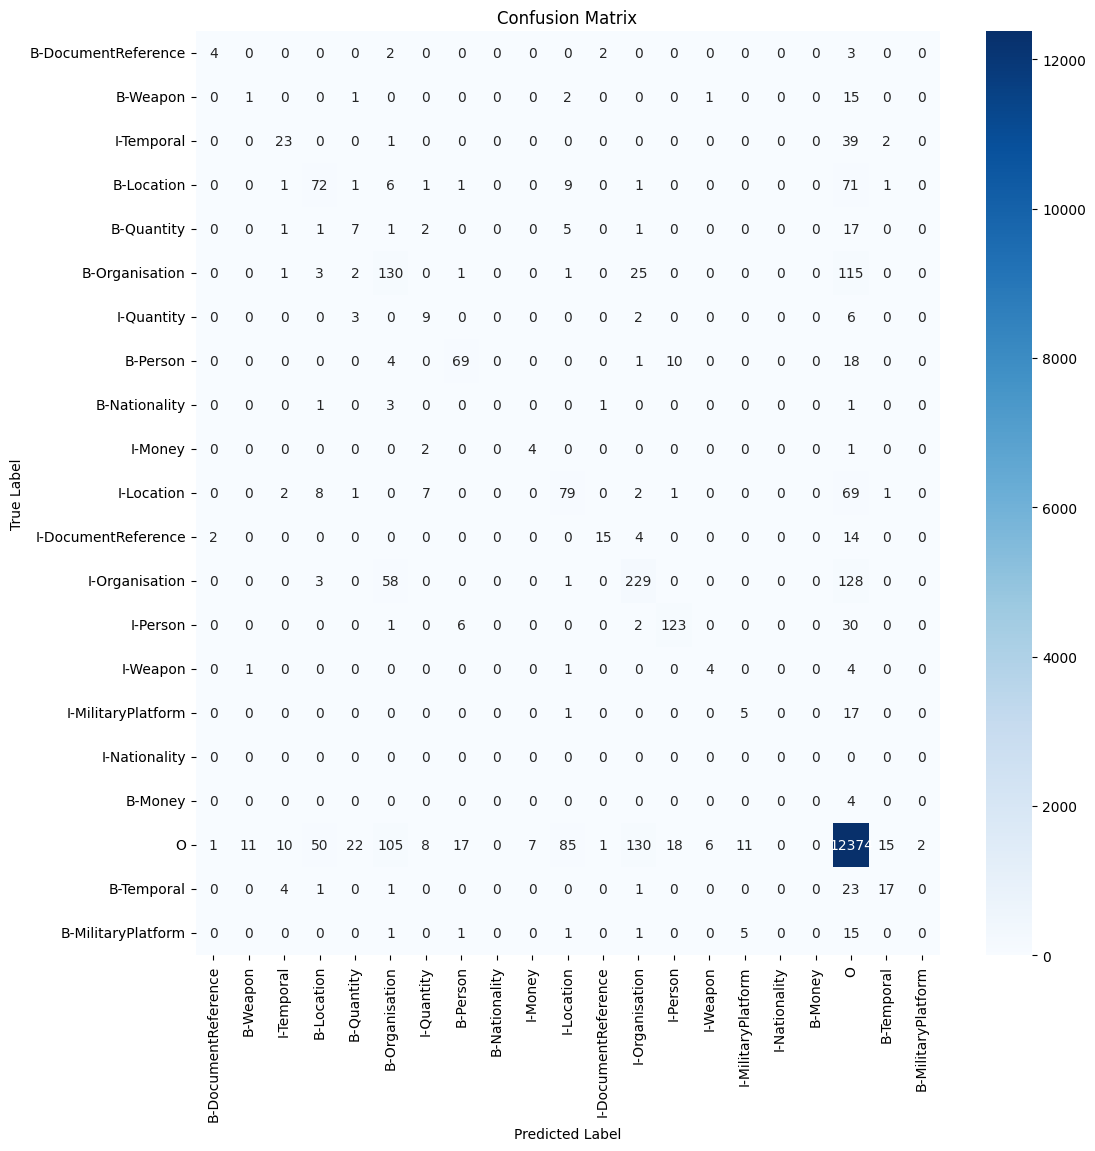

In [ ]:
!pip install matplotlib
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Flatten the lists before passing them to classification_report
valid_tags_flat = [item for sublist in valid_tags for item in sublist]
pred_tags_flat = [item for sublist in pred_tags for item in sublist]

# Print classification report
print(classification_report(valid_tags_flat, pred_tags_flat))

# Generate and display confusion matrix
conf_mat = confusion_matrix(valid_tags_flat, pred_tags_flat, labels=tags_vals)

# Plot confusion matrix using seaborn for better visualization
plt.figure(figsize=(12, 12))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=tags_vals, yticklabels=tags_vals)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.yticks(rotation=0)   # Keep y-axis labels horizontal
plt.show()